In [6]:
#lstm在输入一串连续质数时预估下一个质数
# 使用 numpy实现 LSTM
import random

import numpy as np
import math

def sigmoid(x): 
    return 1. / (1 + np.exp(-x))

# createst uniform random array w/ values in [a,b) and shape args
# a,b区间随机数，(*args)矩阵行列数
def rand_arr(a, b, *args): 
    np.random.seed(0)
    return np.random.rand(*args) * (b - a) + a

# 参数
class LstmParam:
    def __init__(self, mem_cell_ct, x_dim):
        self.mem_cell_ct = mem_cell_ct
        self.x_dim = x_dim
        # Xc(t) = [X(t),H(t-1)]
        concat_len = x_dim + mem_cell_ct
        # 权重矩阵 weight matrices
        self.wg = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wi = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len) 
        self.wf = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wo = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        # 偏置 bias terms
        self.bg = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bi = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bf = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bo = rand_arr(-0.1, 0.1, mem_cell_ct) 
        # 权重偏置梯度 diffs (derivative of loss function w.r.t. all parameters)
        self.wg_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wi_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wf_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wo_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.bg_diff = np.zeros(mem_cell_ct) 
        self.bi_diff = np.zeros(mem_cell_ct) 
        self.bf_diff = np.zeros(mem_cell_ct) 
        self.bo_diff = np.zeros(mem_cell_ct) 
    # 更新权重和偏置 new_w = w - w_diff
    def apply_diff(self, lr = 1):
        self.wg -= lr * self.wg_diff
        self.wi -= lr * self.wi_diff
        self.wf -= lr * self.wf_diff
        self.wo -= lr * self.wo_diff
        self.bg -= lr * self.bg_diff
        self.bi -= lr * self.bi_diff
        self.bf -= lr * self.bf_diff
        self.bo -= lr * self.bo_diff
        # 梯度归 0
        self.wg_diff = np.zeros_like(self.wg)
        self.wi_diff = np.zeros_like(self.wi) 
        self.wf_diff = np.zeros_like(self.wf) 
        self.wo_diff = np.zeros_like(self.wo) 
        self.bg_diff = np.zeros_like(self.bg)
        self.bi_diff = np.zeros_like(self.bi) 
        self.bf_diff = np.zeros_like(self.bf) 
        self.bo_diff = np.zeros_like(self.bo) 
# 状态
class LstmState:
    def __init__(self, mem_cell_ct, x_dim):
        self.g = np.zeros(mem_cell_ct)
        self.i = np.zeros(mem_cell_ct)
        self.f = np.zeros(mem_cell_ct)
        self.o = np.zeros(mem_cell_ct)
        self.s = np.zeros(mem_cell_ct)
        self.h = np.zeros(mem_cell_ct)
        self.bottom_diff_h = np.zeros_like(self.h)
        self.bottom_diff_s = np.zeros_like(self.s)
        self.bottom_diff_x = np.zeros(x_dim)
# LSTM各节点    
class LstmNode:
    def __init__(self, lstm_param, lstm_state):
        # 状态和参数 store reference to parameters and to activations
        self.state = lstm_state
        self.param = lstm_param
        # 输入x(t) 节点的非经常性输入 non-recurrent input to node
        self.x = None
        # 输入x(t)和 h(t-1) 非经常性输入与经常性输入同时进行 non-recurrent input concatenated with recurrent input
        self.xc = None
    # 前向传播
    def bottom_data_is(self, x, s_prev = None, h_prev = None):
        # 首节点
        if s_prev is None:
            s_prev = np.zeros_like(self.state.s)
        if h_prev is None:
            h_prev = np.zeros_like(self.state.h)
        # 为反向传播存储数据
        self.s_prev = s_prev
        self.h_prev = h_prev

        # 拼接 x(t) and h(t-1)为 xc
        xc = np.hstack((x,  h_prev))
        # 定义参数方程
        self.state.g = np.tanh(np.dot(self.param.wg, xc) + self.param.bg)
        self.state.i = sigmoid(np.dot(self.param.wi, xc) + self.param.bi)
        self.state.f = sigmoid(np.dot(self.param.wf, xc) + self.param.bf)
        self.state.o = sigmoid(np.dot(self.param.wo, xc) + self.param.bo)
        self.state.s = self.state.g * self.state.i + s_prev * self.state.f
        self.state.h = self.state.s * self.state.o
        
        self.x = x
        self.xc = xc
# 导数计算    
    def top_diff_is(self, top_diff_h, top_diff_s):
        # notice that top_diff_s is carried along the constant error carousel
        ds = self.state.o * top_diff_h + top_diff_s
        do = self.state.s * top_diff_h
        di = self.state.g * ds
        dg = self.state.i * ds
        df = self.s_prev * ds

        # diffs w.r.t. vector inside sigma / tanh function
        # sigmoid导数
        di_input = (1. - self.state.i) * self.state.i * di 
        df_input = (1. - self.state.f) * self.state.f * df 
        do_input = (1. - self.state.o) * self.state.o * do 
        # tanh 导数
        dg_input = (1. - self.state.g ** 2) * dg

        # 权重和偏置导数 diffs w.r.t. inputs
        self.param.wi_diff += np.outer(di_input, self.xc)
        self.param.wf_diff += np.outer(df_input, self.xc)
        self.param.wo_diff += np.outer(do_input, self.xc)
        self.param.wg_diff += np.outer(dg_input, self.xc)
        
        self.param.bi_diff += di_input
        self.param.bf_diff += df_input       
        self.param.bo_diff += do_input
        self.param.bg_diff += dg_input       

        # compute bottom diff
        dxc = np.zeros_like(self.xc)
        dxc += np.dot(self.param.wi.T, di_input)
        dxc += np.dot(self.param.wf.T, df_input)
        dxc += np.dot(self.param.wo.T, do_input)
        dxc += np.dot(self.param.wg.T, dg_input)

        # save bottom diffs
        self.state.bottom_diff_s = ds * self.state.f
        self.state.bottom_diff_x = dxc[:self.param.x_dim]
        self.state.bottom_diff_h = dxc[self.param.x_dim:]
# LSTM网络
class LstmNetwork():
    def __init__(self, lstm_param):
        self.lstm_param = lstm_param
        self.lstm_node_list = []
        # input sequence
        self.x_list = []
    # 输出节点遍历
    def y_list_is(self, y_list, loss_layer):
        """
        Updates diffs by setting target sequence 
        with corresponding loss layer. 
        Will *NOT* update parameters.  To update parameters,
        call self.lstm_param.apply_diff()
        """
        assert len(y_list) == len(self.x_list)
        idx = len(self.x_list) - 1
        # first node only gets diffs from label ...
        loss = loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx])
        diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
        # here s is not affecting loss due to h(t+1), hence we set equal to zero
        diff_s = np.zeros(self.lstm_param.mem_cell_ct)
        self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
        idx -= 1

        ### ... following nodes also get diffs from next nodes, hence we add diffs to diff_h
        ### we also propagate error along constant error carousel using diff_s
        while idx >= 0:
            loss += loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h += self.lstm_node_list[idx + 1].state.bottom_diff_h
            diff_s = self.lstm_node_list[idx + 1].state.bottom_diff_s
            self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
            idx -= 1 

        return loss

    def x_list_clear(self):
        self.x_list = []

    def x_list_add(self, x):
        self.x_list.append(x)
        if len(self.x_list) > len(self.lstm_node_list):
            # need to add new lstm node, create new state mem
            lstm_state = LstmState(self.lstm_param.mem_cell_ct, self.lstm_param.x_dim)
            self.lstm_node_list.append(LstmNode(self.lstm_param, lstm_state))

        # get index of most recent x input
        idx = len(self.x_list) - 1
        if idx == 0:
            # no recurrent inputs yet
            self.lstm_node_list[idx].bottom_data_is(x)
        else:
            s_prev = self.lstm_node_list[idx - 1].state.s
            h_prev = self.lstm_node_list[idx - 1].state.h
            self.lstm_node_list[idx].bottom_data_is(x, s_prev, h_prev)
# 损失函数
class ToyLossLayer:
    """
    Computes square loss with first element of hidden layer array.
    """
    # 损失函数定义
    @classmethod
    def loss(self, pred, label):
        return (pred[0] - label) ** 2
    # 节点输出求导
    @classmethod
    def bottom_diff(self, pred, label):
        diff = np.zeros_like(pred)
        diff[0] = 2 * (pred[0] - label)
        return diff

In [7]:
#lstm在输入一串连续质数时预估下一个质数
# 测试
import numpy as np

# from lstm import LstmParam, LstmNetwork, ToyLossLayer

def example_0():
    # learns to repeat simple sequence from random inputs
    np.random.seed(0)
    # 隐藏层节点数和词向量维度
    # parameters for input data dimension and lstm cell count 
    mem_cell_ct = 100
    x_dim = 50

    # 实例化 LSTM 参数及网络
    lstm_param = LstmParam(mem_cell_ct, x_dim) 
    lstm_net = LstmNetwork(lstm_param)
    
    # 前项输出
    y_list = [-0.5,0.2,0.1, -0.5]
    # y_list个x_dim维0-1数组
    input_val_arr = [np.random.random(x_dim) for _ in y_list]

    for cur_iter in range(100):
        print("cur iter: ", cur_iter)
        for ind in range(len(y_list)):
            lstm_net.x_list_add(input_val_arr[ind])
            print("y_pred[%d] : %f" % (ind, lstm_net.lstm_node_list[ind].state.h[0]))
        loss = lstm_net.y_list_is(y_list, ToyLossLayer)
        print("loss: ", loss)
        lstm_param.apply_diff(lr=0.1)
        lstm_net.x_list_clear()

if __name__ == "__main__":
    example_0()

cur iter:  0
y_pred[0] : 0.041349
y_pred[1] : 0.069304
y_pred[2] : 0.116993
y_pred[3] : 0.165624
loss:  0.7534838862531601
cur iter:  1
y_pred[0] : -0.223297
y_pred[1] : -0.323066
y_pred[2] : -0.394514
y_pred[3] : -0.433984
loss:  0.5990650839532332
cur iter:  2
y_pred[0] : -0.140715
y_pred[1] : -0.181836
y_pred[2] : -0.219436
y_pred[3] : -0.238904
loss:  0.4450955656992026
cur iter:  3
y_pred[0] : -0.138010
y_pred[1] : -0.166091
y_pred[2] : -0.203394
y_pred[3] : -0.233627
loss:  0.42806160570148644
cur iter:  4
y_pred[0] : -0.139986
y_pred[1] : -0.157368
y_pred[2] : -0.195655
y_pred[3] : -0.237612
loss:  0.4135817110961427
cur iter:  5
y_pred[0] : -0.144410
y_pred[1] : -0.151859
y_pred[2] : -0.191676
y_pred[3] : -0.246137
loss:  0.39977044238183834
cur iter:  6
y_pred[0] : -0.150306
y_pred[1] : -0.147921
y_pred[2] : -0.189501
y_pred[3] : -0.257119
loss:  0.3861363803837694
cur iter:  7
y_pred[0] : -0.157119
y_pred[1] : -0.144659
y_pred[2] : -0.188067
y_pred[3] : -0.269322
loss:  0.372

LSTM model: LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)>
Epoch: [100/10000], Loss:0.00085
Epoch: [200/10000], Loss:0.00040
Epoch: [300/10000], Loss:0.00032
Epoch: [400/10000], Loss:0.00020
Epoch: [500/10000], Loss:0.00017
Epoch: [600/10000], Loss:0.00015
Epoch: [700/10000], Loss:0.00014
Epoch: [800/10000], Loss:0.00014
Epoch: [900/10000], Loss:0.00014
Epoch: [1000/10000], Loss:0.00013
Epoch: [1100/10000], Loss:0.00012
Epoch: [1200/10000], Loss:0.00012
Epoch: [1300/10000], Loss:0.00011
Epoch: [1400/10000], Loss:0.00011
Epoch: [1500/10000], Loss:0.00011
Epoch: [1600/10000], Loss:0.00010
Epoch [1684/10000], Loss: 0.00010
The loss value is reached


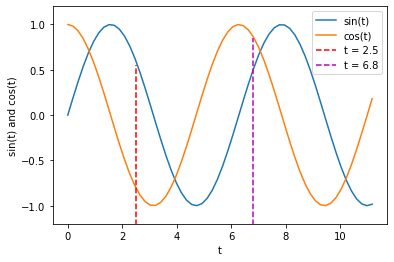

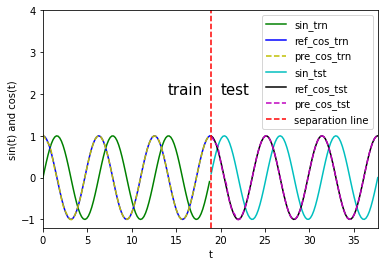

In [5]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Define LSTM Neural Networks
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # utilize the LSTM model in torch.nn 
        self.forwardCalculation = nn.Linear(hidden_size, output_size)
 
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.forwardCalculation(x)
        x = x.view(s, b, -1)
        return x

if __name__ == '__main__':
    # create database
    data_len = 200
    t = np.linspace(0, 12*np.pi, data_len)
    sin_t = np.sin(t)
    cos_t = np.cos(t)

    dataset = np.zeros((data_len, 2))
    dataset[:,0] = sin_t
    dataset[:,1] = cos_t
    dataset = dataset.astype('float32')

    # plot part of the original dataset
    plt.figure()
    plt.plot(t[0:60], dataset[0:60,0], label='sin(t)')
    plt.plot(t[0:60], dataset[0:60,1], label = 'cos(t)')
    plt.plot([2.5, 2.5], [-1.3, 0.55], 'r--', label='t = 2.5') # t = 2.5
    plt.plot([6.8, 6.8], [-1.3, 0.85], 'm--', label='t = 6.8') # t = 6.8
    plt.xlabel('t')
    plt.ylim(-1.2, 1.2)
    plt.ylabel('sin(t) and cos(t)')
    plt.legend(loc='upper right')

    # choose dataset for training and testing
    train_data_ratio = 0.5 # Choose 80% of the data for testing
    train_data_len = int(data_len*train_data_ratio)
    train_x = dataset[:train_data_len, 0]
    train_y = dataset[:train_data_len, 1]
    INPUT_FEATURES_NUM = 1
    OUTPUT_FEATURES_NUM = 1
    t_for_training = t[:train_data_len]

    # test_x = train_x
    # test_y = train_y
    test_x = dataset[train_data_len:, 0]
    test_y = dataset[train_data_len:, 1]
    t_for_testing = t[train_data_len:]

    # ----------------- train -------------------
    train_x_tensor = train_x.reshape(-1, 5, INPUT_FEATURES_NUM) # set batch size to 5
    train_y_tensor = train_y.reshape(-1, 5, OUTPUT_FEATURES_NUM) # set batch size to 5
 
    # transfer data to pytorch tensor
    train_x_tensor = torch.from_numpy(train_x_tensor)
    train_y_tensor = torch.from_numpy(train_y_tensor)
    # test_x_tensor = torch.from_numpy(test_x)
 
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 16, output_size=OUTPUT_FEATURES_NUM, num_layers=1) # 16 hidden units
    print('LSTM model:', lstm_model)
    print('model.parameters:', lstm_model.parameters)
 
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
 
    max_epochs = 10000
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
        if loss.item() < 1e-4:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, max_epochs, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch+1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch+1, max_epochs, loss.item()))
 
    # prediction on training dataset
    predictive_y_for_training = lstm_model(train_x_tensor)
    predictive_y_for_training = predictive_y_for_training.view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    # torch.save(lstm_model.state_dict(), 'model_params.pkl') # save model parameters to files
 
    # ----------------- test -------------------
    # lstm_model.load_state_dict(torch.load('model_params.pkl'))  # load model parameters from files
    lstm_model = lstm_model.eval() # switch to testing model

    # prediction on test dataset
    test_x_tensor = test_x.reshape(-1, 5, INPUT_FEATURES_NUM) # set batch size to 5, the same value with the training set
    test_x_tensor = torch.from_numpy(test_x_tensor)
 
    predictive_y_for_testing = lstm_model(test_x_tensor)
    predictive_y_for_testing = predictive_y_for_testing.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
 
    # ----------------- plot -------------------
    plt.figure()
    plt.plot(t_for_training, train_x, 'g', label='sin_trn')
    plt.plot(t_for_training, train_y, 'b', label='ref_cos_trn')
    plt.plot(t_for_training, predictive_y_for_training, 'y--', label='pre_cos_trn')

    plt.plot(t_for_testing, test_x, 'c', label='sin_tst')
    plt.plot(t_for_testing, test_y, 'k', label='ref_cos_tst')
    plt.plot(t_for_testing, predictive_y_for_testing, 'm--', label='pre_cos_tst')

    plt.plot([t[train_data_len], t[train_data_len]], [-1.2, 4.0], 'r--', label='separation line') # separation line

    plt.xlabel('t')
    plt.ylabel('sin(t) and cos(t)')
    plt.xlim(t[0], t[-1])
    plt.ylim(-1.2, 4)
    plt.legend(loc='upper right')
    plt.text(14, 2, "train", size = 15, alpha = 1.0)
    plt.text(20, 2, "test", size = 15, alpha = 1.0)

    plt.show()

LSTM model: LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)
model.parameters: <bound method Module.parameters of LstmRNN(
  (lstm): LSTM(1, 16)
  (forwardCalculation): Linear(in_features=16, out_features=1, bias=True)
)>
Epoch: [100/10000], Loss:0.00076
Epoch: [200/10000], Loss:0.00048
Epoch: [300/10000], Loss:0.00016
Epoch: [400/10000], Loss:0.00014
Epoch: [500/10000], Loss:0.00013
Epoch: [600/10000], Loss:0.00012
Epoch: [700/10000], Loss:0.00013
Epoch: [800/10000], Loss:0.00011
Epoch: [900/10000], Loss:0.00011
Epoch: [1000/10000], Loss:0.00011
Epoch: [1100/10000], Loss:0.00011
Epoch [1188/10000], Loss: 0.00010
The loss value is reached


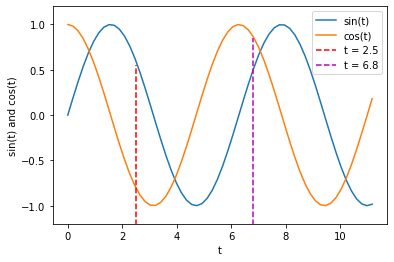

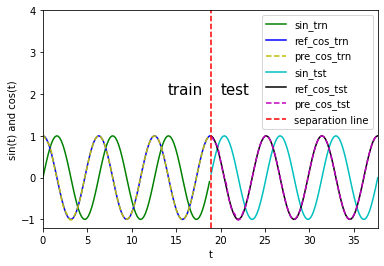

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Define LSTM Neural Networks
class LstmRNN(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # utilize the LSTM model in torch.nn 
        self.forwardCalculation = nn.Linear(hidden_size, output_size)
 
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.forwardCalculation(x)
        x = x.view(s, b, -1)
        return x

if __name__ == '__main__':
    # create database
    data_len = 200
    t = np.linspace(0, 12*np.pi, data_len)
    sin_t = np.sin(t)
    cos_t = np.cos(t)

    dataset = np.zeros((data_len, 2))
    dataset[:,0] = sin_t
    dataset[:,1] = cos_t
    dataset = dataset.astype('float32')

    # plot part of the original dataset
    plt.figure()
    plt.plot(t[0:60], dataset[0:60,0], label='sin(t)')
    plt.plot(t[0:60], dataset[0:60,1], label = 'cos(t)')
    plt.plot([2.5, 2.5], [-1.3, 0.55], 'r--', label='t = 2.5') # t = 2.5
    plt.plot([6.8, 6.8], [-1.3, 0.85], 'm--', label='t = 6.8') # t = 6.8
    plt.xlabel('t')
    plt.ylim(-1.2, 1.2)
    plt.ylabel('sin(t) and cos(t)')
    plt.legend(loc='upper right')

    # choose dataset for training and testing
    train_data_ratio = 0.5 # Choose 80% of the data for testing
    train_data_len = int(data_len*train_data_ratio)
    train_x = dataset[:train_data_len, 0]
    train_y = dataset[:train_data_len, 1]
    INPUT_FEATURES_NUM = 1
    OUTPUT_FEATURES_NUM = 1
    t_for_training = t[:train_data_len]

    # test_x = train_x
    # test_y = train_y
    test_x = dataset[train_data_len:, 0]
    test_y = dataset[train_data_len:, 1]
    t_for_testing = t[train_data_len:]

    # ----------------- train -------------------
    train_x_tensor = train_x.reshape(-1, 5, INPUT_FEATURES_NUM) # set batch size to 5
    train_y_tensor = train_y.reshape(-1, 5, OUTPUT_FEATURES_NUM) # set batch size to 5
 
    # transfer data to pytorch tensor
    train_x_tensor = torch.from_numpy(train_x_tensor)
    train_y_tensor = torch.from_numpy(train_y_tensor)
    # test_x_tensor = torch.from_numpy(test_x)
 
    lstm_model = LstmRNN(INPUT_FEATURES_NUM, 16, output_size=OUTPUT_FEATURES_NUM, num_layers=1) # 16 hidden units
    print('LSTM model:', lstm_model)
    print('model.parameters:', lstm_model.parameters)
 
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
 
    max_epochs = 10000
    for epoch in range(max_epochs):
        output = lstm_model(train_x_tensor)
        loss = loss_function(output, train_y_tensor)
 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
        if loss.item() < 1e-4:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, max_epochs, loss.item()))
            print("The loss value is reached")
            break
        elif (epoch+1) % 100 == 0:
            print('Epoch: [{}/{}], Loss:{:.5f}'.format(epoch+1, max_epochs, loss.item()))
 
    # prediction on training dataset
    predictive_y_for_training = lstm_model(train_x_tensor)
    predictive_y_for_training = predictive_y_for_training.view(-1, OUTPUT_FEATURES_NUM).data.numpy()

    # torch.save(lstm_model.state_dict(), 'model_params.pkl') # save model parameters to files
 
    # ----------------- test -------------------
    # lstm_model.load_state_dict(torch.load('model_params.pkl'))  # load model parameters from files
    lstm_model = lstm_model.eval() # switch to testing model

    # prediction on test dataset
    test_x_tensor = test_x.reshape(-1, 5, INPUT_FEATURES_NUM) # set batch size to 5, the same value with the training set
    test_x_tensor = torch.from_numpy(test_x_tensor)
 
    predictive_y_for_testing = lstm_model(test_x_tensor)
    predictive_y_for_testing = predictive_y_for_testing.view(-1, OUTPUT_FEATURES_NUM).data.numpy()
 
    # ----------------- plot -------------------
    plt.figure()
    plt.plot(t_for_training, train_x, 'g', label='sin_trn')
    plt.plot(t_for_training, train_y, 'b', label='ref_cos_trn')
    plt.plot(t_for_training, predictive_y_for_training, 'y--', label='pre_cos_trn')

    plt.plot(t_for_testing, test_x, 'c', label='sin_tst')
    plt.plot(t_for_testing, test_y, 'k', label='ref_cos_tst')
    plt.plot(t_for_testing, predictive_y_for_testing, 'm--', label='pre_cos_tst')

    plt.plot([t[train_data_len], t[train_data_len]], [-1.2, 4.0], 'r--', label='separation line') # separation line

    plt.xlabel('t')
    plt.ylabel('sin(t) and cos(t)')
    plt.xlim(t[0], t[-1])
    plt.ylim(-1.2, 4)
    plt.legend(loc='upper right')
    plt.text(14, 2, "train", size = 15, alpha = 1.0)
    plt.text(20, 2, "test", size = 15, alpha = 1.0)

    plt.show()